# Potential Talents - An Apziva Project (#3)

By Samuel Alter

Apziva: 6bImatZVlK6DnbEo

# Proceed to the [previous notebook](potential_talents_pt2_ranknet.ipynb) to view my work on RankNet.

## Project Overview

We are working with a talent sourcing and management company to help them surface candidates that are a best fit for their human resources job post. We are using a dataset of job candidates' job titles, their location, and their number of LinkedIn connections.

### Goals

Produce a probability, between 0 and 1, of how closely the candidate fits the job description of **"Aspiring human resources"** or **"Seeking human resources."** After an initial recommendation pulls out a candidate(s) to be starred for future consideration, the recommendation will be re-run and new "stars" will be awarded.

To help predict how the candidates fit, we are tracking the performance of two success metrics:
* Rank candidates based on a fitness score
* Re-rank candidates when a candidate is starred

We also need to do the following:
* Explain how the algorithm works and how the ranking improves after each starring iteration
* How to filter out candidates which should not be considered at all
* Determine a cut-off point (if possible) that would work for other roles without losing high-potential candidates
* Ideas to explore on automating this procedure to reduce or eliminate human bias

### The Dataset

| Column | Data Type | Comments |
|---|---|---|
| `id` | Numeric | Unique identifier for the candidate |
| `job_title` | Text | Job title for the candidate |
| `location` | Text | Geographic location of the candidate |
| `connections` | Text | Number of LinkedIn connections for the candidate |

Connections over 500 are encoded as "500+". Some do not have specific locations listed and just had their country, so I substituted capitol cities or geographic centers to represent those countries.

# Imports and Helper Functions

In [190]:
# to install pandas, use
# pip install 'lightgbm[pandas]'
# or
# pip install 'lightgbm[scikit-learn]'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import torch
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import optuna

# use
# pip install optuna-integration[lightgbm]
from optuna.integration import LightGBMPruningCallback

# LambdaRank

In an effort to explore other ranking algorithms, we will now turn to LambdaRank. It is an evolution of the RankNet algorithm that we worked on above. While RankNet looks to optimize pairwise accuracy, LambdaRank optimizes for ranking metrics like NDCG, or Normalized Discounted Cumulative Gain. It does not require pairwise comparisons as input. 

NDCG checks not only if the first item should be ranked higher than the second, but also how much swapping their order would improve the final ranking. The gain can be thought of this way: if a relevant item is placed close to the top, it will have a greater gain than if a relevant item was placed towards the bottom. 

LambdaRank uses **lambdas** that help adjust the model's focus to help improve the overall ranking quality, while RankNet takes advantage of a loss function and cares about individual rankings.

You can read more about LambdaRank [here](https://tamaracucumides.medium.com/learning-to-rank-with-lightgbm-code-example-in-python-843bd7b44574). There's a short snippet of information about LambdaRank [from Microsoft](https://www.microsoft.com/en-us/research/publication/from-ranknet-to-lambdarank-to-lambdamart-an-overview/). Researchers there designed the algorithm.

[This repository](https://github.com/Ransaka/LTR-with-LIghtGBM) gives a good example of how to implement the algorithm.

LambdaRank uses the LightGBM algorithm and requires the following:
* **Feature matrix (X)** of each item
* **Relevance scores (y)** for each item
* "**Groups**," or the number of items per query group 

In [8]:
# get random seed from project
with open('seed.txt', 'r') as file:
    seed = int(file.read())
    
seed

2870

In [75]:
# set the randomness seed throughout the notebook
# source: # https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

## set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
## set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
## set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
np.random.default_rng(seed)

Generator(PCG64) at 0x31612B760

In [48]:
# load the job title data
loaded_data = np.load('../joblib/3_job_title.npz', allow_pickle=True)
job_title_sbert = [np.array(embedding) for embedding in loaded_data['embeddings']]
print(f"Loaded {len(job_title_sbert)} embeddings. First element type: {type(job_title_sbert[0])}")

Loaded 104 embeddings. First element type: <class 'numpy.ndarray'>


In [49]:
# convert back to tensors
job_title_tensors = [torch.tensor(embedding) for embedding in job_title_sbert]

In [50]:
# check
job_title_tensors[0]

tensor([-7.1764e-02,  2.2637e-03, -1.7858e-02,  3.1808e-02,  8.6310e-03,
         4.5645e-02, -6.7703e-02,  3.1216e-02,  1.8814e-02, -3.6150e-04,
        -1.5786e-02, -3.0461e-02, -8.2910e-02, -5.0705e-02, -7.0172e-02,
         3.2520e-02,  9.6550e-03, -8.0883e-02,  4.6644e-02, -3.8407e-02,
         2.3128e-02,  3.6828e-02, -1.5138e-03, -9.5810e-02, -2.7337e-02,
        -3.0467e-02, -1.6989e-02, -2.4439e-02, -2.1443e-04, -3.0366e-03,
         1.0420e-02,  5.6600e-03,  2.4441e-02,  3.2096e-02,  6.2465e-02,
         6.9278e-02,  4.4225e-02, -1.1663e-02,  1.5852e-01,  3.1511e-02,
        -9.2587e-03, -8.1887e-02, -2.8538e-02,  3.3625e-02, -6.5775e-03,
        -5.9914e-02,  2.1527e-02, -3.0205e-02,  3.8459e-02, -8.4312e-03,
        -7.3194e-02, -6.0277e-02,  3.9353e-02, -4.5725e-02,  2.8139e-02,
         3.0143e-02,  2.7823e-02, -1.5330e-02,  6.5976e-03, -6.2322e-02,
        -1.5916e-02, -3.1975e-02,  2.1324e-02,  3.4776e-02,  8.1722e-02,
         5.2771e-03, -5.2103e-02,  2.3793e-02,  3.8

In [51]:
# load candidate ID and rank data
with open('../joblib/candidate_ids.pkl', 'rb') as f:
    candidate_ids = pickle.load(f)

with open('../joblib/ranks.pkl', 'rb') as f:
    ranks = pickle.load(f)
    
print("Data loaded successfully.")

Data loaded successfully.


In [62]:
# check
candidate_ids[:5]

[1, 2, 3, 4, 5]

In [61]:
# check
ranks[:5]

[1, 1, 2, 2, 16]

## Prepare the data

Now that we have our work from the previous notebook loaded, we will adapt them to the needs of the LambdaRank algorithm:
* **Feature matrix (X)** will be the `job_titles`
* **Relevance scores (y)** will be the `ranks`
* **Group** equals `1` as we're looking at all candidates

In [166]:
# convert ranks to relevance scores (invert ranks: higher rank -> higher score)
# example: if ranks are 1, 2, 3, scores become 3, 2, 1.
relevance_scores = np.max(ranks) - np.array(ranks) + 1

# feature matrix (X) from job_titles
X = np.array([job.detach().cpu().numpy() for job in job_titles])

# we'll define group in the next code cell

print('Done.')

Done.


## Split the data

In [167]:
# split data into training+validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, relevance_scores, test_size=0.2, random_state=seed
)

group_train_val = [len(X_train_val)]
group_test = [len(X_test)]

# split val set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=seed
) # 0.25 x (1.0 - test_size) = 0.2, so validation set is 20% of the original data

group_train = [len(X_train)]
group_val = [len(X_val)]

print('Done.')

Done.


## Train the LambdaRank model

In [168]:
# initialize LambdaRank model
ranker = lgb.LGBMRanker(
    objective='lambdarank',
    boosting_type='gbdt',
    metric='ndcg', # evaluation metric
    n_estimators=100,
    learning_rate=0.1,
    importance_type='gain',
    random_state=seed
)

# train model
ranker.fit(
    X_train, y_train,
    group=group_train,
    eval_set=[(X_val, y_val)],
    eval_group=[group_val],
    eval_at=[5, 10] # evaluate nDCG at 5 and 10
)

LGBMRanker(importance_type='gain', metric='ndcg', objective='lambdarank',
           random_state=2870)

## Test and evaluate

In [169]:
# predict relevance scores
y_pred = ranker.predict(X_test)

# sort test data by predicted relevance
sorted_indices = np.argsort(-y_pred)  # descending order
sorted_candidates = np.array(candidate_ids)[sorted_indices]
sorted_relevance = y_pred[sorted_indices]

for candidate, score in zip(sorted_candidates, sorted_relevance):
    print(f'Candidate ID: {candidate}, Predicted score: {score}')

Candidate ID: 4, Predicted score: 0.6831914069355659
Candidate ID: 6, Predicted score: 0.6831914069355659
Candidate ID: 12, Predicted score: 0.3220738111400713
Candidate ID: 7, Predicted score: -0.08345109119203761
Candidate ID: 20, Predicted score: -0.38079116232617805
Candidate ID: 10, Predicted score: -0.5287622853540623
Candidate ID: 8, Predicted score: -0.6810206733100771
Candidate ID: 1, Predicted score: -0.8063554906169652
Candidate ID: 5, Predicted score: -0.8063554906169652
Candidate ID: 14, Predicted score: -0.9363888925878047
Candidate ID: 3, Predicted score: -1.1099522058990874
Candidate ID: 21, Predicted score: -1.1579183721186497
Candidate ID: 17, Predicted score: -1.1596234836195072
Candidate ID: 13, Predicted score: -1.3191721782739276
Candidate ID: 18, Predicted score: -1.3280857072905452
Candidate ID: 9, Predicted score: -1.3280857072905452
Candidate ID: 15, Predicted score: -1.3971962323856422
Candidate ID: 11, Predicted score: -1.3971962323856422
Candidate ID: 2, Pr

In [170]:
# define true relevance
# sorted by prediction order
true_relevance = relevance_scores[sorted_indices]

# compute NDCG at k
ndcg = ndcg_score([true_relevance], [sorted_relevance], k=5)
print(f'NDCG@5: {ndcg:.4f}')

NDCG@5: 0.9223


A score of close to 1.0 means that the model did a good job of prioritizing the most relevant candidates.

In [171]:
def mean_reciprocal_rank(y_true, y_pred):
    # sort by predicted relevance (descending)
    sorted_indices = np.argsort(-y_pred)
    # align true relevance with predictions
    y_true_sorted = np.array(y_true)[sorted_indices]

    for i, relevance in enumerate(y_true_sorted):
        if relevance > 0:  # Find first relevant item
            return 1 / (i + 1)
    return 0  # no relevant items found

mrr = mean_reciprocal_rank(true_relevance, sorted_relevance)
print(f'MRR: {mrr:.4f}')

MRR: 1.0000


The MRR is the average of the reciprocal ranks (1 for first place, 1/2 for second place, 1/3 for third place, and so on). Values closer to 1 mean that the model did a good job of ordering candidates.

In [154]:
# Define objective function
def objective(trial):
    params = {
        'objective': 'lambdarank',
        'boosting_type': 'gbdt',
        'metric': 'ndcg',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 1.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 1.0),
        'random_state': seed,
        'verbose': -1
    }
    
    ranker = lgb.LGBMRanker(**params)
    ranker.fit(
        X_train, y_train,
        group=group_train,
        eval_set=[(X_val, y_val)],
        eval_group=[group_val],
        eval_at=[5],
        callbacks=[LightGBMPruningCallback(trial, 'ndcg@5')]
    )
    
    # Evaluate on validation set
    y_val_pred = ranker.predict(X_val)
    ndcg_val = ndcg_score([y_val], [y_val_pred], k=5)
    return ndcg_val

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Best parameters
print("Best parameters:", study.best_params)

[I 2024-12-09 16:07:37,069] A new study created in memory with name: no-name-8b438754-4f18-4e41-a90f-e83008a27485
[I 2024-12-09 16:07:37,135] Trial 0 finished with value: 0.44483628264122543 and parameters: {'n_estimators': 92, 'learning_rate': 0.20600957285172575, 'num_leaves': 86, 'min_child_samples': 6, 'lambda_l1': 0.31028586816229964, 'lambda_l2': 0.22612113650999954}. Best is trial 0 with value: 0.44483628264122543.
[I 2024-12-09 16:07:37,184] Trial 1 finished with value: 0.44483628264122543 and parameters: {'n_estimators': 139, 'learning_rate': 0.2702910348178481, 'num_leaves': 68, 'min_child_samples': 5, 'lambda_l1': 0.36000831071409345, 'lambda_l2': 0.9362894048484816}. Best is trial 0 with value: 0.44483628264122543.
[I 2024-12-09 16:07:37,213] Trial 2 finished with value: 0.2780234140403975 and parameters: {'n_estimators': 317, 'learning_rate': 0.1920844489304878, 'num_leaves': 41, 'min_child_samples': 46, 'lambda_l1': 0.27598606046249774, 'lambda_l2': 0.33859543150136573}. 

[I 2024-12-09 16:07:40,224] Trial 35 pruned. Trial was pruned at iteration 0.
[I 2024-12-09 16:07:40,242] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2024-12-09 16:07:40,266] Trial 37 pruned. Trial was pruned at iteration 0.
[I 2024-12-09 16:07:40,544] Trial 38 finished with value: 0.3742799893827492 and parameters: {'n_estimators': 468, 'learning_rate': 0.012397096559755516, 'num_leaves': 73, 'min_child_samples': 9, 'lambda_l1': 0.05877839980835757, 'lambda_l2': 0.49148387369704616}. Best is trial 15 with value: 0.5440217798834552.
[I 2024-12-09 16:07:40,564] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2024-12-09 16:07:40,589] Trial 40 pruned. Trial was pruned at iteration 0.
[I 2024-12-09 16:07:40,764] Trial 41 finished with value: 0.5440217798834552 and parameters: {'n_estimators': 418, 'learning_rate': 0.06936958883617866, 'num_leaves': 62, 'min_child_samples': 6, 'lambda_l1': 0.16081633058344588, 'lambda_l2': 0.9313343270806285}. Best is trial 15 with value: 0.54

Best parameters: {'n_estimators': 430, 'learning_rate': 0.18719608636701013, 'num_leaves': 38, 'min_child_samples': 11, 'lambda_l1': 0.1526949959196216, 'lambda_l2': 0.6325436315566935}


In [157]:
best_params = study.best_params

# add verbosity to quiet LightGBM
best_params['verbose_eval'] = -1
best_params['verbose'] = -1
best_params['random_state'] = seed

print(best_params)

{'n_estimators': 430, 'learning_rate': 0.18719608636701013, 'num_leaves': 38, 'min_child_samples': 11, 'lambda_l1': 0.1526949959196216, 'lambda_l2': 0.6325436315566935, 'verbose_eval': -1, 'verbose': -1, 'random_state': 2870}


In [163]:
ranker = lgb.LGBMRanker(**best_params)

# train model
ranker.fit(
    X_train, y_train,
    group=group_train,
    eval_set=[(X_val, y_val)],
    eval_group=[group_val],
    eval_at=[5, 10] # evaluate nDCG at 5 and 10
)

# predict relevance scores
y_pred = ranker.predict(X_test)

# sort test data by predicted relevance
sorted_indices = np.argsort(-y_pred)  # descending order
sorted_candidates = np.array(candidate_ids)[sorted_indices]
sorted_relevance = y_pred[sorted_indices]

for candidate, score in zip(sorted_candidates, sorted_relevance):
    print(f'Candidate ID: {candidate}, Predicted score: {score}')
    
# define true relevance
# sorted by prediction order
true_relevance = relevance_scores[sorted_indices]

# compute NDCG at k
k = 5
ndcg = ndcg_score([true_relevance], [sorted_relevance], k=k)
print(f'NDCG@{k}: {ndcg:.4f}')

def mean_reciprocal_rank(y_true, y_pred):
    # sort by predicted relevance (descending)
    sorted_indices = np.argsort(-y_pred)
    # align true relevance with predictions
    y_true_sorted = np.array(y_true)[sorted_indices]

    for i, relevance in enumerate(y_true_sorted):
        if relevance > 0:  # Find first relevant item
            return 1 / (i + 1)
    return 0  # no relevant items found

mrr = mean_reciprocal_rank(true_relevance, sorted_relevance)
print(f'MRR: {mrr:.4f}')

Candidate ID: 4, Predicted score: 0.7663084384535309
Candidate ID: 6, Predicted score: 0.7663084384535309
Candidate ID: 12, Predicted score: 0.4909646730878631
Candidate ID: 8, Predicted score: -0.09639600399202215
Candidate ID: 7, Predicted score: -0.12105775407176772
Candidate ID: 10, Predicted score: -0.30899133177130483
Candidate ID: 20, Predicted score: -0.3649820095617594
Candidate ID: 14, Predicted score: -0.5128243497864965
Candidate ID: 21, Predicted score: -0.6092002482989524
Candidate ID: 1, Predicted score: -0.7334190941346933
Candidate ID: 5, Predicted score: -0.7334190941346933
Candidate ID: 3, Predicted score: -0.8174556252498346
Candidate ID: 13, Predicted score: -1.0761780266041392
Candidate ID: 18, Predicted score: -1.1578137497569059
Candidate ID: 9, Predicted score: -1.1578137497569059
Candidate ID: 17, Predicted score: -1.1855504711324176
Candidate ID: 15, Predicted score: -1.2223797506820304
Candidate ID: 11, Predicted score: -1.2223797506820304
Candidate ID: 2, P

Interestingly, the tuned model produced a worse result. We will use the base model for our visualization and wrap-up.

### Plot results

In [172]:
# initialize LambdaRank model
ranker = lgb.LGBMRanker(
    objective='lambdarank',
    boosting_type='gbdt',
    metric='ndcg', # evaluation metric
    n_estimators=100,
    learning_rate=0.1,
    importance_type='gain',
    random_state=seed
)

# train model
ranker.fit(
    X_train, y_train,
    group=group_train,
    eval_set=[(X_val, y_val)],
    eval_group=[group_val],
    eval_at=[5, 10] # evaluate nDCG at 5 and 10
)

# predict relevance scores
y_pred = ranker.predict(X_test)

# sort test data by predicted relevance
sorted_indices = np.argsort(-y_pred)  # descending order
sorted_candidates = np.array(candidate_ids)[sorted_indices]
sorted_relevance = y_pred[sorted_indices]

for candidate, score in zip(sorted_candidates, sorted_relevance):
    print(f'Candidate ID: {candidate}, Predicted score: {score}')
    
# define true relevance
# sorted by prediction order
true_relevance = relevance_scores[sorted_indices]

# compute NDCG at k
ndcg = ndcg_score([true_relevance], [sorted_relevance], k=5)
print(f'NDCG@5: {ndcg:.4f}')

def mean_reciprocal_rank(y_true, y_pred):
    # sort by predicted relevance (descending)
    sorted_indices = np.argsort(-y_pred)
    # align true relevance with predictions
    y_true_sorted = np.array(y_true)[sorted_indices]

    for i, relevance in enumerate(y_true_sorted):
        if relevance > 0:  # Find first relevant item
            return 1 / (i + 1)
    return 0  # no relevant items found

mrr = mean_reciprocal_rank(true_relevance, sorted_relevance)
print(f'MRR: {mrr:.4f}')

Candidate ID: 4, Predicted score: 0.6831914069355659
Candidate ID: 6, Predicted score: 0.6831914069355659
Candidate ID: 12, Predicted score: 0.3220738111400713
Candidate ID: 7, Predicted score: -0.08345109119203761
Candidate ID: 20, Predicted score: -0.38079116232617805
Candidate ID: 10, Predicted score: -0.5287622853540623
Candidate ID: 8, Predicted score: -0.6810206733100771
Candidate ID: 1, Predicted score: -0.8063554906169652
Candidate ID: 5, Predicted score: -0.8063554906169652
Candidate ID: 14, Predicted score: -0.9363888925878047
Candidate ID: 3, Predicted score: -1.1099522058990874
Candidate ID: 21, Predicted score: -1.1579183721186497
Candidate ID: 17, Predicted score: -1.1596234836195072
Candidate ID: 13, Predicted score: -1.3191721782739276
Candidate ID: 18, Predicted score: -1.3280857072905452
Candidate ID: 9, Predicted score: -1.3280857072905452
Candidate ID: 15, Predicted score: -1.3971962323856422
Candidate ID: 11, Predicted score: -1.3971962323856422
Candidate ID: 2, Pr

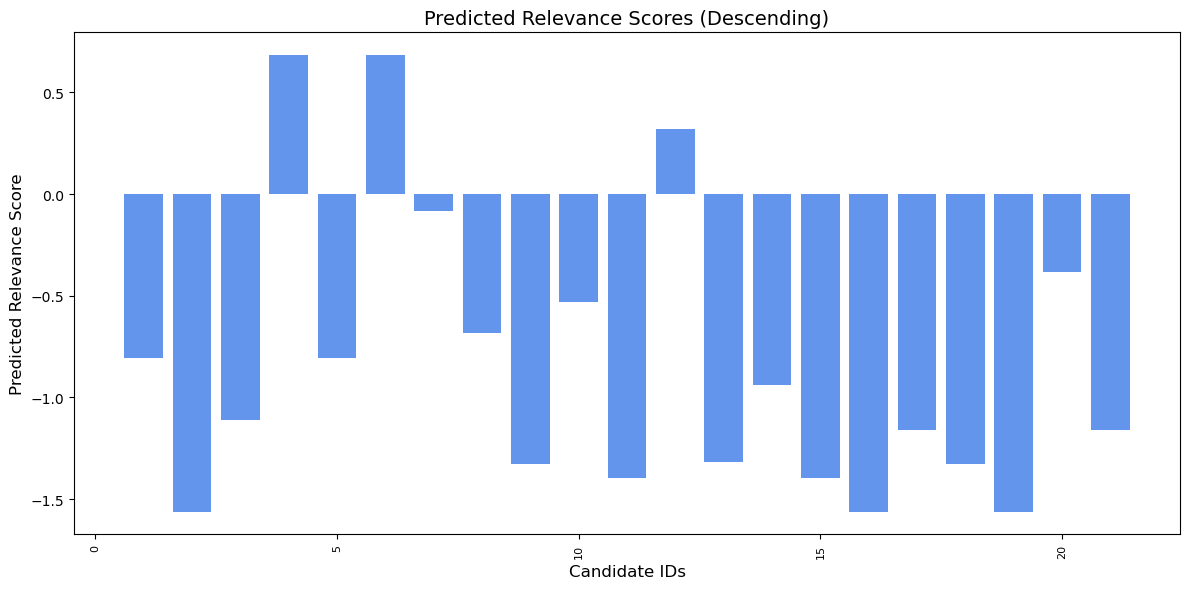

In [175]:
# predicted relevance scores
plt.figure(figsize=(12, 6))
plt.bar(sorted_candidates, sorted_relevance, color='cornflowerblue')
plt.xlabel('Candidate IDs', fontsize=12)
plt.ylabel('Predicted Relevance Score', fontsize=12)
plt.title('Predicted Relevance Scores (Descending)', fontsize=14)
plt.xticks(rotation=90, fontsize=8)  # Rotate x-axis labels for readability
plt.tight_layout()

plt.savefig('figures/3_predicted_relevance.jpg', bbox_inches='tight')

plt.show()

Explanation here

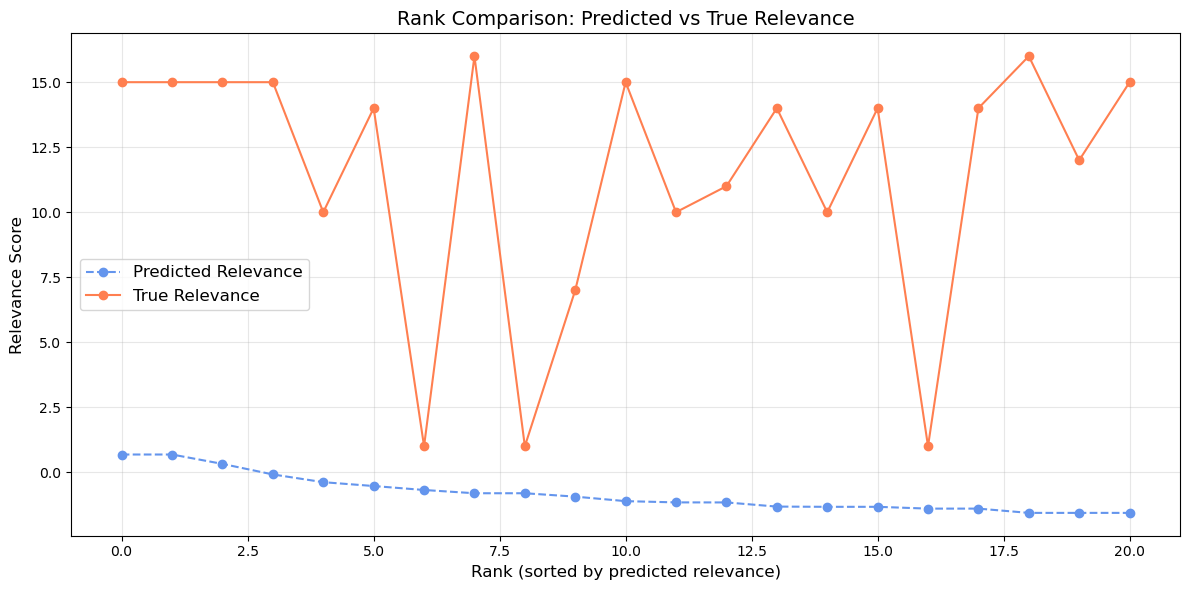

In [192]:
# rank comparison: Predicted vs. True relevance
plt.figure(figsize=(12, 6))
plt.plot(range(len(sorted_relevance)), sorted_relevance, label='Predicted Relevance', marker='o', linestyle='--', color='cornflowerblue')
plt.plot(range(len(true_relevance)), true_relevance, label='True Relevance', marker='o', linestyle='-', color='coral')
plt.xlabel('Rank (sorted by predicted relevance)', fontsize=12)
plt.ylabel('Relevance Score', fontsize=12)
plt.title('Rank Comparison: Predicted vs True Relevance', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig('figures/3_predicted_vs_true_relevance.jpg', bbox_inches='tight')

plt.show()

Explanation here

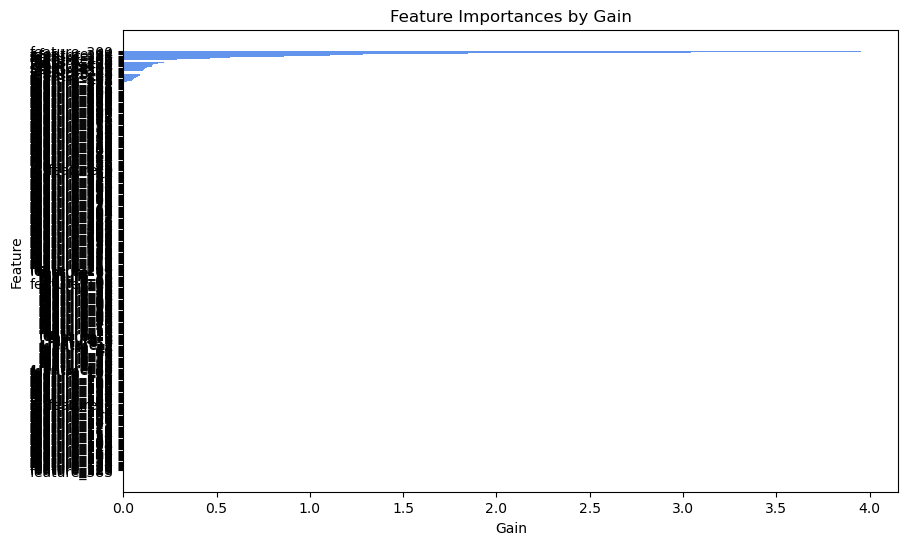

         Feature      Gain  Frequency  Gain_Percentage  Frequency_Percentage
300  feature_300  3.955590          1        25.146050              1.785714
64    feature_64  3.041415          7        19.334554             12.500000
382  feature_382  1.844840          1        11.727818              1.785714
74    feature_74  1.286620          1         8.179162              1.785714
145  feature_145  1.108450          1         7.046519              1.785714
..           ...       ...        ...              ...                   ...
131  feature_131  0.000000          0         0.000000              0.000000
130  feature_130  0.000000          0         0.000000              0.000000
129  feature_129  0.000000          0         0.000000              0.000000
128  feature_128  0.000000          0         0.000000              0.000000
383  feature_383  0.000000          0         0.000000              0.000000

[384 rows x 5 columns]


In [195]:
# retrieve the underlying Booster object
booster = ranker.booster_

# generate placeholder feature names
feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

# get feature importances using gain (or another importance type)
importance_df = pd.DataFrame({
    'Feature': feature_names,  # replace with actual feature names
    'Gain': booster.feature_importance(importance_type='gain'),
    'Frequency': booster.feature_importance(importance_type='split'),
})

# compute percentages (optional)
importance_df['Gain_Percentage'] = (
    importance_df['Gain'] / importance_df['Gain'].sum() * 100
)
importance_df['Frequency_Percentage'] = (
    importance_df['Frequency'] / importance_df['Frequency'].sum() * 100
)

# sort by gain for visualization
importance_df = importance_df.sort_values(by='Gain', ascending=False)

# plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Gain'], color='cornflowerblue')
plt.xlabel('Gain')
plt.ylabel('Feature')
plt.title('Feature Importances by Gain')
plt.gca().invert_yaxis()  # most important features at the top

# plt.savefig('figures/3_feature_importances', bbox_inches='tight')

plt.show()

# print the table for inspection
print(importance_df)